# DiploDatos Kaggle Competition

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

## Fuente de datos

Competencia de Kaggle para la diplomatura 👉 [https://www.kaggle.com/competitions/aprendizaje-supervisado-2022/data](https://www.kaggle.com/competitions/aprendizaje-supervisado-2022/data).

## Descripción de las variables

* **PassengerId**: Una identificación única para cada pasajero. Cada Id toma la forma gggg_pp donde gggg indica un grupo con el que viaja el pasajero y pp es su número dentro del grupo. Las personas en un grupo a menudo son miembros de la familia, pero no siempre.
* **HomePlanet**: El planeta del que partió el pasajero, normalmente su planeta de residencia permanente.
* **CryoSleep**: Indica si el pasajero eligió ponerse en animación suspendida durante la duración del viaje. Los pasajeros en criosueño están confinados en sus cabinas.
* **Cabina**: El número de cabina donde se hospeda el pasajero. Toma la forma cubierta/número/lado, donde lado puede ser P para babor o S para estribor.
* **Destino**: El planeta al que desembarcará el pasajero.
* **Edad**: La edad del pasajero.
* **VIP**: Si el pasajero ha pagado por un servicio VIP especial durante el viaje.
* **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**: Monto que el pasajero ha facturado en cada uno de los muchos servicios de lujo del Spaceship Titanic.
* **Nombre**: El nombre y apellido del pasajero.
* **Transportado**: Si el pasajero fue transportado a otra dimensión. Este es el objetivo, la columna que está tratando de predecir.

## Importaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

%matplotlib inline

## Constantes

In [2]:
SEMILLA = 8

# Ubicación de los datos para entrenamiento
URL= 'https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/train.csv'

# Ubicación de los datos para evaluación
URL_VAL='https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/test.csv'

## Lectura de datos

In [3]:
df = pd.read_csv(URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7823 entries, 0 to 7822
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   7823 non-null   int64  
 1   HomePlanet    7644 non-null   object 
 2   CryoSleep     7627 non-null   object 
 3   Cabin         7639 non-null   object 
 4   Destination   7663 non-null   object 
 5   Age           7661 non-null   float64
 6   VIP           7639 non-null   object 
 7   RoomService   7669 non-null   float64
 8   FoodCourt     7668 non-null   float64
 9   ShoppingMall  7635 non-null   float64
 10  Spa           7665 non-null   float64
 11  VRDeck        7654 non-null   float64
 12  Name          7639 non-null   object 
 13  Transported   7823 non-null   int64  
dtypes: float64(6), int64(2), object(6)
memory usage: 855.8+ KB


## Visualización de datos

Por medio del método pairplot.

Text(0.5, 1.01, 'Correlation Between Numeric Variables and Transportation')

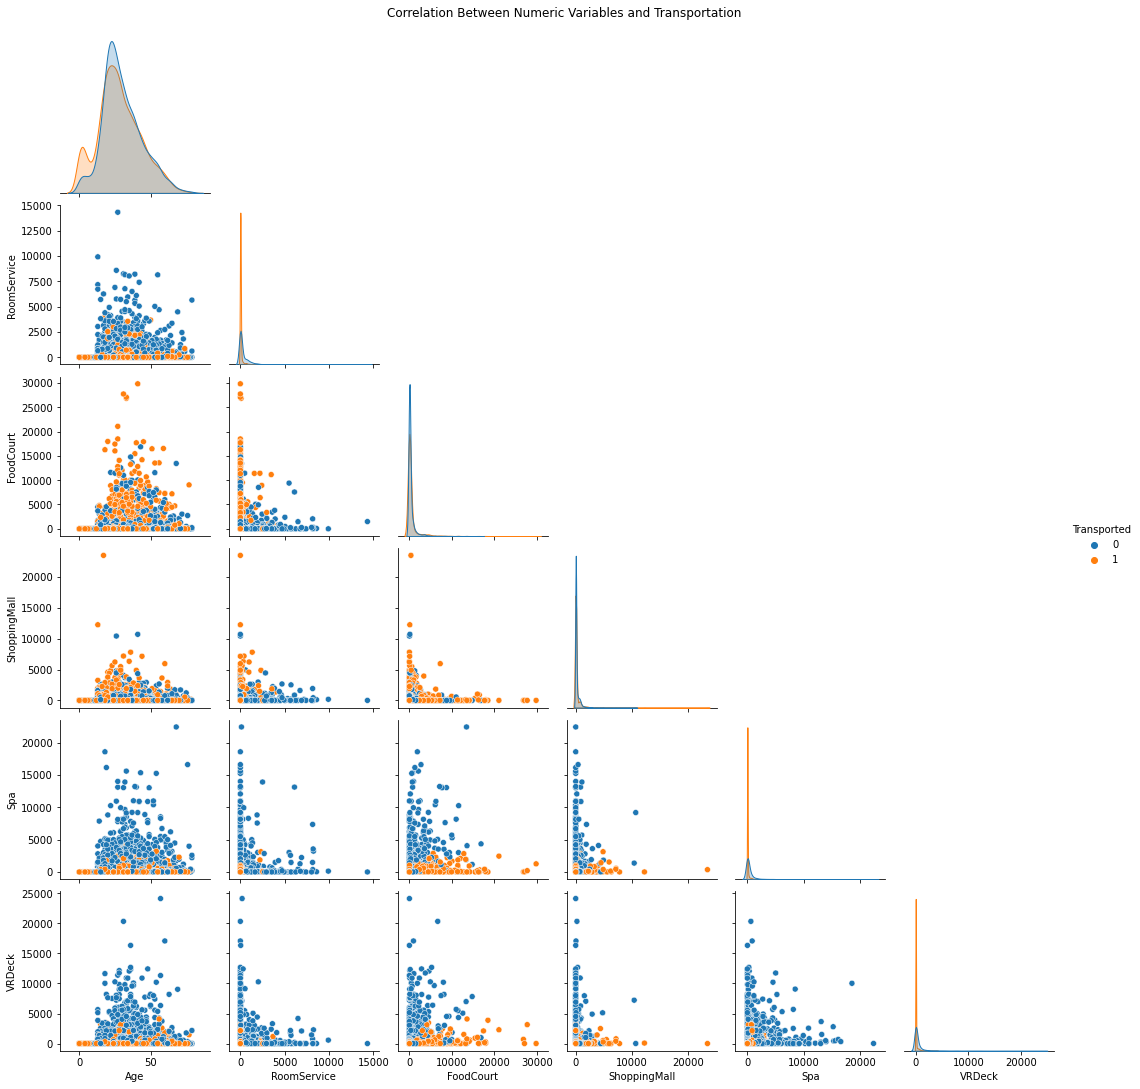

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for_visual = df.select_dtypes(include=numerics).copy()
for_visual['Transported'] = df['Transported']
g = sns.pairplot(for_visual[['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']],hue = 'Transported', corner = True)
g.fig.suptitle("Correlation Between Numeric Variables and Transportation", y = 1.01)

Los gráficos muestran, por un lado, que en una primera instancia no se puede atribuir una asociación lineal entre las variables numéricas tomadas de a pares. Además las distribuciones de cada variable no se corresponden con distribuciones simétricas.

## Exploración de datos faltantes

Usamos la librería missingno para intentar encontrar la causa de la pérdida de valores en el conjunto de entrenamiento.

<AxesSubplot:>

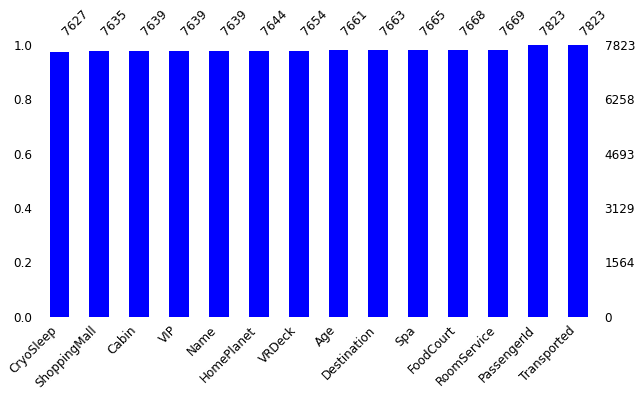

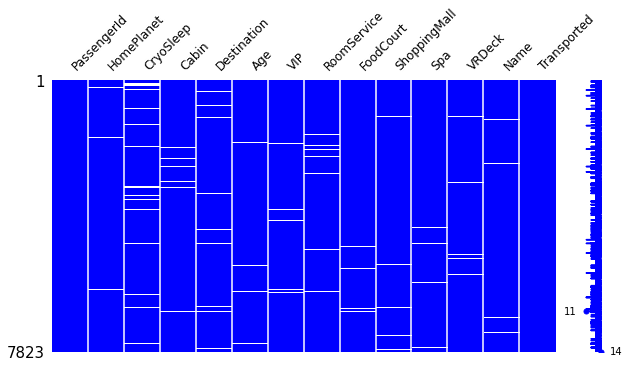

In [5]:
msno.bar(df, figsize=(10, 5), sort="ascending", fontsize=12, color=[0, 0, 1])
msno.matrix(df, figsize=(10, 5), fontsize=12, color=[0, 0, 1])

## Imputación de datos

### Primera imputación:

La primera imputación consiste en compretar algunos datos faltantes de:
  - RoomService
  - FoodCourt
  - ShoppingMall
  - Spa
  - VRDeck
  
Los pasajeros que eligieron ponerse en animación suspendida (CryoSleep = True) durante todo el viaje, por cuestiones obvias, no gastaron en ninguno de los servicios de lujo del Spaceship Titanic.

En virtud de ello **se imputarán gastos nulos a las personas en animación suspendida**, ya que la probabilidad de que una persona en animación suspendida no haya gastado es del 100%.

In [6]:
cant_registros = df.shape[0]
columnas_gastos = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [7]:
for i in range(cant_registros):
    if (pd.isna(df.loc[i, columnas_gastos]).sum() > 0 and
        df.at[i, "CryoSleep"]):
        # Si fala al menos un valor de gastos Y
        # el pasajero se encuentra en animación suspendida
        df.loc[i, columnas_gastos] = 0.0

### Segunda imputación:

Imputación de valores faltantes de CryoSleep.

  - En caso de que el pasajero haya tenido algún gasto se le imputa valor False. Esto es debido a que si gastó dinero es seguro que no se hallaba en animación suspendida.
  - En caso de que el pasajero no haya tenido gasto, o los valores de gastos no estén presentes, se le imputa valor True. No es 100% probable que si la persona no gastó se halle en animación suspendida. Existe un 78% de probabilidad que así sea, por lo que se decide hacer tal imputación.

In [8]:
for i in range(cant_registros):
    if (df.loc[i, columnas_gastos].sum() > 0 and
        pd.isna(df.at[i, "CryoSleep"])):
        # Si el pasajero tuvo algún gasto Y
        # falta el valor de CryoSleep
        df.loc[i, "CryoSleep"] = False
        # Existe un 100% de probabilidad que así sea

In [9]:
for i in range(cant_registros):
    if (df.loc[i, columnas_gastos].sum() == 0 and
        pd.isna(df.at[i, "CryoSleep"])):
        # Si el pasajero no tuvo gastos Y
        # falta valor de CryoSleep
        df.loc[i, "CryoSleep"] = True
        # Existe un 78% de probabilidad que así sea
        if pd.isna(df.loc[i, columnas_gastos]).sum() > 0:
            df.loc[i, columnas_gastos] = 0.0
        # En caso de que falten valores de gastos se les imputan valores nulos
        # No es 100% probable que esía sea, pero dado que se trata de 11 de 90 casos
        # difícilmente influya negativamente en el resultado.

### Tercera imputación:

Imputación de valores faltantes de VIP.

Como solamente el 3% de los pasajeros en animación suspendida son VIP, se imputa según el siguiente criterio sin temor a una influencia negativa en los resultados:

  - Si se encuentra en animación suspendida se asume que no es pasajero VIP.
  - Si no se encuentra en animación suspendida se asume que es pasajero VIP.

In [10]:
for i in range(cant_registros):
    if pd.isna(df.at[i, "VIP"]):
        df.loc[i, "VIP"] = not(df.loc[i, "CryoSleep"])

In [11]:
for i in range(cant_registros):
    if (df.loc[i, columnas_gastos].sum() > 0 and
        df.at[i, "CryoSleep"] == np.nan):
        # Si el pasajero tuvo algún gasto y falta
        # valor de CryoSleep
        df.loc[i, "CryoSleep"] = False
    elif (df.loc[i, columnas_gastos].sum() == 0 and
          df.at[i, "CryoSleep"] == np.nan):
        # Si el pasajero no tuvo gastos y falta
        # valor de CryoSleep
        df.loc[i, "CryoSleep"] = True
        if df.loc[i, columnas_gastos].isna().sum() > 0:
            df.loc[i, columnas_gastos] = 0.0

### Cuarta imputación:

Imputación de valores faltantes de gastos.

Imputación simple que corresponde al promedio de los gastos.

In [12]:
imputer = SimpleImputer()
df[columnas_gastos] = imputer.fit_transform(df[columnas_gastos])

### Quinta imputación:

Imputación de valores faltantes de edad.

Imputación simple que corresponde al promedio de las edades.

In [13]:
imputer = SimpleImputer()
df[["Age"]] = imputer.fit_transform(df[["Age"]])

### Sexta imputación:

Imputación de valores faltantes de nombres.

Se asigna valor "NN" a las personas cuyo dato de nombre no se encuentre.

In [14]:
df.Name.fillna(value='NN', inplace=True)

### Séptima imputación:

Imputación de valores faltantes de HomePlanet, Cabin y Destination.

Se utiliza el criterio del valor más frecuente.

In [15]:
imputer_cols = ['HomePlanet', 'Cabin', 'Destination']
imputer = SimpleImputer(strategy="most_frequent")
df[imputer_cols] = imputer.fit_transform(df[imputer_cols])

Corroboramos que no queden valores faltantes en nuestro data set.

In [16]:
df.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

Tras la limpieza de datos se aprecia que se dispone de un dataset de entrenamiento equilibrado entre transportados y no transportados.

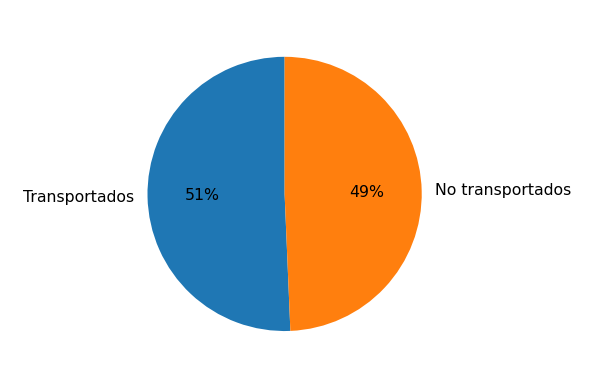

In [17]:
transportados = df[df.Transported == 1].shape[0]
no_transportados = df[df.Transported == 0].shape[0]

etiquetas = ['Transportados', 'No transportados']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie([transportados, no_transportados],
        labels=etiquetas,
        textprops={'fontsize': 5},
        startangle=90,
        autopct='%1.0f%%')
plt.show()

## Transformaciones (encoding) de variables categóricas

### Primer encoding: Cabina

Antes del encoding se separa por piso y lado de la nave.

Tras el encoding quedan columnas para cada lado y piso de la nave.

In [18]:
df_cabina = df.Cabin.str.split("/", expand=True)

In [19]:
df1 = pd.get_dummies(df_cabina[2]).rename(columns = {"P": "Port", "S": "Starboard"})
df1.head()

,Port,Starboard
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0


In [20]:
df2 = pd.get_dummies(df_cabina[0], prefix='piso')
df2.head()

,piso_A,piso_B,piso_C,piso_D,piso_E,piso_F,piso_G,piso_T
0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0


### Segundo encoding: Planeta de Origen

In [21]:
df3 = pd.get_dummies(df.HomePlanet)
df3.head()

,Earth,Europa,Mars
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,1,0,0


### Tercer encoding: Destino

In [22]:
df4 = pd.get_dummies(df.Destination)
df4.head()

,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


Eliminación de las columnas a las que se hicieron las transformaciones.

Se eliminan también las columnas Name y PassengerId. Estas no se utilizarán para entrenar los modelos por no tratarse de datos numéricos.

La información de PassengerID se conserva para el armado de la salida.

In [23]:
passenger_id = df.PassengerId

df.drop(["Cabin", "HomePlanet", "Destination", "Name", "PassengerId"], axis=1, inplace=True)
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,False,57.0,False,0.0,3859.0,13.0,195.0,3874.0,0
1,True,18.0,False,0.0,0.0,0.0,0.0,0.0,1
2,True,33.0,False,0.0,0.0,0.0,0.0,0.0,1
3,False,43.0,False,142.0,1208.0,0.0,0.0,204.0,0
4,False,19.0,False,0.0,0.0,670.0,1.0,34.0,0


## Separación de datos de entrenamiento y de prueba

Antes de la separación, se convierten los datos booleanos a numéricos, ya que el algoritmo XGBoost daría error.

In [24]:
df[["CryoSleep", "VIP"]] = df[["CryoSleep", "VIP"]].astype(int)

In [25]:
X = pd.concat([df, df1, df2, df3], axis=1)
X.drop(["Transported"], axis=1, inplace=True)

y = df.Transported

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEMILLA)

## Propuesta de modelos

Se proponen a continuación diferentes modelos para los cuales se hace búsqueda de hiperparámetros según el siguiente detalle:

|Modelo|Búsqueda de hiperparámetros|
|:----:|:-------------------------:|
|Descenso de Gradiente Estocástico|Grilla|
|Árbol de decisión|Grilla|
|Bosques aleatorios|Grilla|
|XGBoost Classifier|Aleatorea|

XGBoost es una librería altamente eficiente, flexible y portátil que implementa la técnica aprendizaje automático [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting).

Se puede acceder a la documentación de XGBoost haciendo [click aquí](https://xgboost.readthedocs.io/en/stable/index.html).

Si bien todos los algoritmos arrojan un valor similar de precisión (aproximadamente 0.8 para el conjunto de evaluación), se utilizan los resultados obtenidos con el algoritmo **XGBoost** para generar el archivo de salida `sample_submmission.csv`.

### SGDClassifier

In [27]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

In [28]:
model_1 = SGDClassifier(random_state = SEMILLA)
model_1.fit(X_train_scaled, y_train)

SGDClassifier(random_state=8)

In [29]:
y_pred_1 = model_1.predict(X_train_scaled)
print(classification_report(y_train, y_pred_1))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      3111
           1       0.79      0.78      0.78      3147

    accuracy                           0.78      6258
   macro avg       0.78      0.78      0.78      6258
weighted avg       0.78      0.78      0.78      6258



In [30]:
y_pred_1_test = model_1.predict(X_test_scaled)
print(classification_report(y_test, y_pred_1_test))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       748
           1       0.81      0.78      0.80       817

    accuracy                           0.79      1565
   macro avg       0.79      0.79      0.79      1565
weighted avg       0.79      0.79      0.79      1565



In [31]:
param_grid = {
    'loss': ['hinge', 'perceptron', 'log'],
    'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
}

cv = GridSearchCV(model_1, param_grid, scoring ='accuracy', refit=True, cv=5)
cv.fit(X_train_scaled, y_train);

In [32]:
results = pd.DataFrame(cv.cv_results_)
results[['param_alpha', 'param_loss', 'mean_test_score', 'rank_test_score']]

,param_alpha,param_loss,mean_test_score,rank_test_score
0,0.0001,hinge,0.780602,7
1,0.0001,perceptron,0.733623,21
2,0.0001,log,0.772130,10
3,0.0005,hinge,0.783636,5
4,0.0005,perceptron,0.682495,27
5,0.0005,log,0.790827,1
6,0.001,hinge,0.783000,6
7,0.001,perceptron,0.718926,22
8,0.001,log,0.788111,2
9,0.005,hinge,0.772449,9


### DecisionTreeClassifier

In [33]:
tree_model = DecisionTreeClassifier(random_state=SEMILLA)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=8)

In [34]:
y_pred_2 = tree_model.predict(X_train)

In [35]:
print(classification_report(y_train, y_pred_2))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      3111
           1       0.92      0.96      0.94      3147

    accuracy                           0.94      6258
   macro avg       0.94      0.94      0.94      6258
weighted avg       0.94      0.94      0.94      6258



In [36]:
y_pred_2_test = tree_model.predict(X_test)
print(classification_report(y_test, y_pred_2_test))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       748
           1       0.74      0.77      0.76       817

    accuracy                           0.74      1565
   macro avg       0.74      0.74      0.74      1565
weighted avg       0.74      0.74      0.74      1565



In [37]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 10, 50]
}


cv = GridSearchCV(tree_model, param_grid, scoring ='accuracy', refit=True, cv=5)
cv.fit(X_train, y_train);

In [38]:
results_tree = pd.DataFrame(cv.cv_results_)
results_tree[['param_max_depth', 'param_criterion', 'mean_test_score', 'rank_test_score']]

,param_max_depth,param_criterion,mean_test_score,rank_test_score
0,2,gini,0.726270,7
1,5,gini,0.766698,4
2,10,gini,0.772610,2
3,50,gini,0.744009,6
4,2,entropy,0.726270,7
5,5,entropy,0.766698,3
6,10,entropy,0.773888,1
7,50,entropy,0.747364,5


### RandomForestClassifier

In [39]:
model_3 = RandomForestClassifier(random_state=SEMILLA)
model_3.fit(X_train, y_train)

RandomForestClassifier(random_state=8)

In [40]:
y_pred_3 = model_3.predict(X_train)
print(classification_report(y_train, y_pred_3))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      3111
           1       0.92      0.97      0.94      3147

    accuracy                           0.94      6258
   macro avg       0.94      0.94      0.94      6258
weighted avg       0.94      0.94      0.94      6258



In [41]:
y_pred_3_test = model_3.predict(X_test)
print(classification_report(y_test, y_pred_3_test))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       748
           1       0.83      0.78      0.80       817

    accuracy                           0.80      1565
   macro avg       0.80      0.80      0.80      1565
weighted avg       0.80      0.80      0.80      1565



In [42]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [43]:
CV_rfc = GridSearchCV(estimator=model_3, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=8),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [44]:
results = pd.DataFrame(CV_rfc.cv_results_)
results[['param_n_estimators',
         'param_criterion',
         'param_max_depth',
         'param_max_features',
         'mean_test_score',
         'rank_test_score']].sort_values(by='rank_test_score').head(5)

,param_n_estimators,param_criterion,param_max_depth,param_max_features,mean_test_score,rank_test_score
59,500,entropy,8,log2,0.799938,1
57,500,entropy,8,sqrt,0.799938,1
55,500,entropy,8,auto,0.799938,1
28,200,gini,8,log2,0.798820,4
26,200,gini,8,sqrt,0.798820,4


In [45]:
best_model_3=CV_rfc.best_estimator_
best_model_3

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=8)

In [46]:
ypred_train_rfc= best_model_3.predict(X_train)

In [47]:
print(classification_report(y_train, ypred_train_rfc))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      3111
           1       0.82      0.84      0.83      3147

    accuracy                           0.83      6258
   macro avg       0.83      0.83      0.83      6258
weighted avg       0.83      0.83      0.83      6258



In [48]:
ypred_test_rfc= best_model_3.predict(X_test)

In [49]:
print(classification_report(y_test, ypred_test_rfc))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       748
           1       0.81      0.80      0.81       817

    accuracy                           0.80      1565
   macro avg       0.80      0.80      0.80      1565
weighted avg       0.80      0.80      0.80      1565



### XGBClassifier

In [50]:
model_4 = XGBClassifier(random_state=SEMILLA)
model_4

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=8, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [51]:
model_4.fit(X_train, y_train)

D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
y_model_4 = model_4.predict(X_train)

In [53]:
print(classification_report(y_train, y_model_4))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      3111
           1       0.88      0.92      0.90      3147

    accuracy                           0.90      6258
   macro avg       0.90      0.90      0.90      6258
weighted avg       0.90      0.90      0.90      6258



In [54]:
y_model_test_4 = model_4.predict(X_test)

In [55]:
print(classification_report(y_test, y_model_test_4))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       748
           1       0.81      0.81      0.81       817

    accuracy                           0.80      1565
   macro avg       0.80      0.80      0.80      1565
weighted avg       0.80      0.80      0.80      1565



In [56]:
parameters_4 = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    'objetive': ['binary:logistic','binary:hinge']
    
}

In [57]:
gs_4 = RandomizedSearchCV(
    estimator=model_4,
    param_distributions=parameters_4,
    scoring = 'accuracy',
    cv = 5,
    random_state = SEMILLA)
gs_4.fit(X_train, y_train)

D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:08] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:09] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:10] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:11] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:12] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:12] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:15] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:17] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:19] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:22] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:24] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:25] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:26] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:27] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:28] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:29] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:31] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:32] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:34] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:36] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:38] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:40] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:43] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:43] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:43] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:43] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:44] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:45] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:46] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:46] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:47] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:48] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:49] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:49] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:50] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:51] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:51] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:53] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:54] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:55] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:57] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:58] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:47:59] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:47:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:01] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:48:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:02] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:48:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:04] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:48:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:48:05] WARNING: ..\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:48:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False, gamma=0,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimat...
                                           num_parallel_tree=1,
                                           predictor='auto', random_state

In [58]:
results_4 = pd.DataFrame(gs_4.cv_results_)
results_4[['param_max_depth',
           'param_n_estimators',
           'param_learning_rate',
           'param_objetive',
           'mean_test_score',
           'rank_test_score']].sort_values(by='rank_test_score').head(5)

,param_max_depth,param_n_estimators,param_learning_rate,param_objetive,mean_test_score,rank_test_score
9,4,180,0.05,binary:hinge,0.802015,1
4,8,140,0.1,binary:logistic,0.800736,2
1,9,140,0.05,binary:hinge,0.799456,3
8,9,60,0.05,binary:logistic,0.799297,4
3,9,60,0.1,binary:hinge,0.798179,5


In [59]:
best_model_4 = gs_4.best_estimator_
best_model_4

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=4,
              num_parallel_tree=1, objetive='binary:hinge', predictor='auto',
              random_state=8, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [60]:
ypred_train_4 = best_model_4.predict(X_train)

In [61]:
print(classification_report(y_train, ypred_train_4))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      3111
           1       0.80      0.87      0.83      3147

    accuracy                           0.82      6258
   macro avg       0.83      0.82      0.82      6258
weighted avg       0.83      0.82      0.82      6258



In [62]:
ypred_test_4 = best_model_4.predict(X_test)

In [63]:
print(classification_report(y_test, ypred_test_4))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       748
           1       0.80      0.84      0.82       817

    accuracy                           0.80      1565
   macro avg       0.81      0.80      0.80      1565
weighted avg       0.81      0.80      0.80      1565



---

## Generación de la salida

### Lectura de datos

In [64]:
df = pd.read_csv(URL_VAL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   870 non-null    int64  
 1   HomePlanet    848 non-null    object 
 2   CryoSleep     849 non-null    object 
 3   Cabin         855 non-null    object 
 4   Destination   848 non-null    object 
 5   Age           853 non-null    float64
 6   VIP           851 non-null    object 
 7   RoomService   843 non-null    float64
 8   FoodCourt     842 non-null    float64
 9   ShoppingMall  850 non-null    float64
 10  Spa           845 non-null    float64
 11  VRDeck        851 non-null    float64
 12  Name          854 non-null    object 
dtypes: float64(6), int64(1), object(6)
memory usage: 88.5+ KB


### Exploración de datos faltantes

<AxesSubplot:>

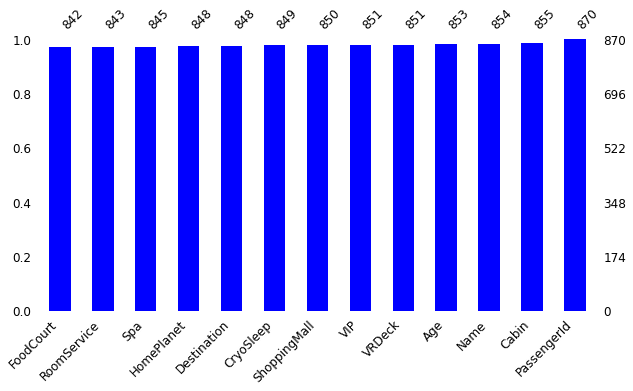

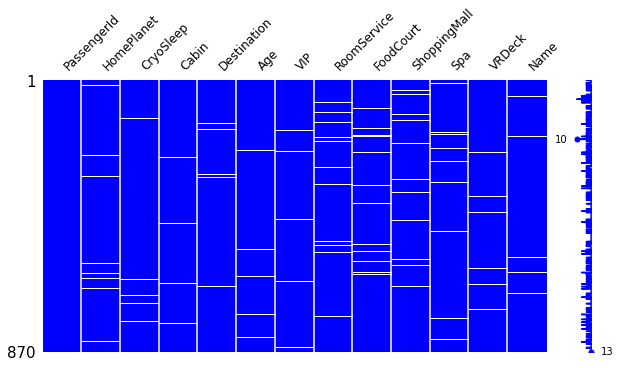

In [65]:
msno.bar(df, figsize=(10, 5), sort="ascending", fontsize=12, color=[0, 0, 1])
msno.matrix(df, figsize=(10, 5), fontsize=12, color=[0, 0, 1])

### Imputación de datos

#### Primera imputación:

In [66]:
cant_registros = df.shape[0]
columnas_gastos = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [67]:
for i in range(cant_registros):
    if (pd.isna(df.loc[i, columnas_gastos]).sum() > 0 and
        df.at[i, "CryoSleep"]):
        # Si fala al menos un valor de gastos Y
        # el pasajero se encuentra en animación suspendida
        df.loc[i, columnas_gastos] = 0.0

#### Segunda imputación:

In [68]:
for i in range(cant_registros):
    if (df.loc[i, columnas_gastos].sum() > 0 and
        pd.isna(df.at[i, "CryoSleep"])):
        # Si el pasajero tuvo algún gasto Y
        # falta el valor de CryoSleep
        df.loc[i, "CryoSleep"] = False
        # Existe un 100% de probabilidad que así sea

In [69]:
for i in range(cant_registros):
    if (df.loc[i, columnas_gastos].sum() == 0 and
        pd.isna(df.at[i, "CryoSleep"])):
        # Si el pasajero no tuvo gastos Y
        # falta valor de CryoSleep
        df.loc[i, "CryoSleep"] = True
        # Existe un 78% de probabilidad que así sea
        if pd.isna(df.loc[i, columnas_gastos]).sum() > 0:
            df.loc[i, columnas_gastos] = 0.0
        # En caso de que falten valores de gastos se les imputan valores nulos
        # No es 100% probable que esía sea, pero dado que se trata de 11 de 90 casos
        # difícilmente influya negativamente en el resultado.

#### Tercera imputación:

In [70]:
for i in range(cant_registros):
    if pd.isna(df.at[i, "VIP"]):
        df.loc[i, "VIP"] = not(df.loc[i, "CryoSleep"])

In [71]:
for i in range(cant_registros):
    if (df.loc[i, columnas_gastos].sum() > 0 and
        df.at[i, "CryoSleep"] == np.nan):
        # Si el pasajero tuvo algún gasto y falta
        # valor de CryoSleep
        df.loc[i, "CryoSleep"] = False
    elif (df.loc[i, columnas_gastos].sum() == 0 and
          df.at[i, "CryoSleep"] == np.nan):
        # Si el pasajero no tuvo gastos y falta
        # valor de CryoSleep
        df.loc[i, "CryoSleep"] = True
        if df.loc[i, columnas_gastos].isna().sum() > 0:
            df.loc[i, columnas_gastos] = 0.0

#### Cuarta imputación

In [72]:
imputer = SimpleImputer()
df[columnas_gastos] = imputer.fit_transform(df[columnas_gastos])

#### Quinta imputación

In [73]:
imputer = SimpleImputer()
df[["Age"]] = imputer.fit_transform(df[["Age"]])

#### Sexta imputación

In [74]:
df.Name.fillna(value='NN', inplace=True)

#### Séptima imputación

In [75]:
imputer_cols = ['HomePlanet', 'Cabin', 'Destination']
imputer = SimpleImputer(strategy="most_frequent")
df[imputer_cols] = imputer.fit_transform(df[imputer_cols])

Corroboramos que no queden valores faltantes en el data set de prueba.

In [76]:
df.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

### Transformaciones (encoding) de variables categóricas

#### Primer encoding: Cabina

In [77]:
df_cabina = df.Cabin.str.split("/", expand=True)

In [78]:
df1 = pd.get_dummies(df_cabina[2]).rename(columns = {"P": "Port", "S": "Starboard"})
df1.head()

,Port,Starboard
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1


In [79]:
df2 = pd.get_dummies(df_cabina[0], prefix='piso')
df2.head()

,piso_A,piso_B,piso_C,piso_D,piso_E,piso_F,piso_G,piso_T
0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0


#### Segundo encoding: Planeta de Origen

In [80]:
df3 = pd.get_dummies(df.HomePlanet)
df3.head()

,Earth,Europa,Mars
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,0


#### Tercer encoding: Destino

In [81]:
df4 = pd.get_dummies(df.Destination)
df4.head()

,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,1,0,0
1,0,1,0
2,0,0,1
3,0,1,0
4,1,0,0


Eliminación de las columnas a las que se hicieron las transformaciones.

Se eliminan también las columnas Name y PassengerId. Estas no se utilizarán para entrenar los modelos por no tratarse de datos numéricos.

La información de PassengerID se conserva para el armado de la salida.

In [82]:
passenger_id = df.PassengerId

df.drop(["Cabin", "HomePlanet", "Destination", "Name", "PassengerId"], axis=1, inplace=True)
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,True,34.0,False,0.0,0.0,0.0,0.0,0.0
1,True,13.0,False,0.0,0.0,0.0,0.0,0.0
2,False,44.0,False,22.0,1.0,0.0,864.0,0.0
3,False,63.0,False,0.0,0.0,80.0,0.0,2322.0
4,False,10.0,False,0.0,0.0,0.0,0.0,0.0


### Armado del dataset X para hacer la predicción

Antes de la separación, se convierten los datos booleanos a numéricos, ya que el algoritmo XGBoost daría error.

In [83]:
df[["CryoSleep", "VIP"]] = df[["CryoSleep", "VIP"]].astype(int)

In [84]:
X = pd.concat([df, df1, df2, df3], axis=1)

## Generar la salida para entregar

In [85]:
test_id = passenger_id
test_pred = best_model_4.predict(X)

In [86]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
submission.to_csv("sample_submission.csv", header=True, index=False)